In [1]:
from __future__ import print_function

import sys
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, TimeDistributed, Dense
from tensorflow.keras.models import Model, load_model

# To import 'katakana' from relative path
import encoding

INPUT_LENGTH = 90
OUTPUT_LENGTH = 90

In [2]:
##### Limit GPU for training ###
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Data pre-processing

In [5]:
data = pd.read_csv('../datasets/hospital_augment_train6_3.csv')
data = data.sample(frac=1, random_state=1)

data_input = list(data['gen_data'])
data_output_temp =  list(data['true_data'])

data_output = ["\t"+s for s in data_output_temp]
print(data_input[0], data_output[0])
print(data_input[5], data_output[5])

data_size = len(data)
a = int(data_size*90/100)

# We will use the first 0-60th %-tile (60%) of data for the training
training_input  = data_input[:a]
training_output = data_output[:a]

# We will use the first 60-70th %-tile (10%) of data for the training
validation_input = data_input[a:]
validation_output = data_output[a:]

print('training size', len(training_input))
print('validation size', len(validation_input))

โรงพยาบาลบ้าฝนค่าย 	โรงพยาบาลบ้านค่าย
คลินิกเวชกรรมกล้วยน้ไทสาขาทุ่งสองห้อง 	คลินิกเวชกรรมกล้วยน้ำไทสาขาทุ่งสองห้อง
training size 77136
validation size 8571


In [6]:
data_output[0]

'\tโรงพยาบาลบ้านค่าย'

### Transform data into Numpy arrays

We transform the sequences of characters into sequences of integer IDs. This will be done by using pre-written functions in `encoding` module. 
- First, `encoding.build_characters_encoding` will build encoding/decoding dictionary from the data. 
- Then, `encoding.transform` will transform the data into numpy array.

Check [the previous notebook](./Writing Katakana using Sequence-to-Sequence in Keras) for the details about the transformation.

In [7]:
input_encoding, input_decoding, input_dict_size = encoding.build_characters_encoding(data_input)
output_encoding, output_decoding, output_dict_size = encoding.build_characters_encoding(data_output)

print('Input character dict size:', input_dict_size)
print('Output character dict size:', output_dict_size)


encoded_training_input = encoding.transform(
    input_encoding, training_input, vector_size=INPUT_LENGTH)
encoded_training_output = encoding.transform(
    output_encoding, training_output, vector_size=OUTPUT_LENGTH)

print('encoded_training_input', encoded_training_input.shape)
print('encoded_training_output', encoded_training_output.shape)

encoded_validation_input = encoding.transform(
    input_encoding, validation_input, vector_size=INPUT_LENGTH)
encoded_validation_output = encoding.transform(
    output_encoding, validation_output, vector_size=OUTPUT_LENGTH)

print('encoded_validation_input', encoded_validation_input.shape)
print('encoded_validation_output', encoded_validation_output.shape)

Input character dict size: 94
Output character dict size: 84
encoded_training_input (77136, 90)
encoded_training_output (77136, 90)
encoded_validation_input (8571, 90)
encoded_validation_output (8571, 90)


In [8]:
import pickle 

In [9]:
import pickle
with open('char2int.pickle', 'wb') as handle:
    pickle.dump(input_encoding, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('int2char.pickle', 'wb') as handle:
    pickle.dump(output_decoding, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Sequence-to-Sequence in Keras

In [10]:
encoder_input = Input(shape=(INPUT_LENGTH,))
decoder_input = Input(shape=(OUTPUT_LENGTH,))

In [7]:
decoder_input

<tf.Tensor 'input_2:0' shape=(None, 90) dtype=float32>

### Encoder / Decoder

In [11]:
from tensorflow.keras.layers import SimpleRNN,Bidirectional,Concatenate
from tensorflow.keras.layers import SimpleRNN

encoder = Embedding(input_dict_size, 64, input_length=INPUT_LENGTH, mask_zero=True)(encoder_input)
encoder = LSTM(128, return_sequences=True, unroll=True)(encoder)
encoder_last = encoder[:,-1,:]

print('encoder', encoder)
print('encoder_last', encoder_last)

decoder = Embedding(output_dict_size, 64, input_length=OUTPUT_LENGTH, mask_zero=True)(decoder_input)
decoder = LSTM(128, return_sequences=True, unroll=True)(decoder, initial_state=[encoder_last, encoder_last])

print('decoder', decoder)

encoder Tensor("lstm/Identity:0", shape=(None, 90, 128), dtype=float32)
encoder_last Tensor("strided_slice:0", shape=(None, 128), dtype=float32)
decoder Tensor("lstm_1/Identity:0", shape=(None, 90, 128), dtype=float32)


In [12]:
encoder.shape,decoder.shape

(TensorShape([None, 90, 128]), TensorShape([None, 90, 128]))

In [13]:
from tensorflow.keras.layers import Activation, dot, concatenate,Attention
'''
attention_layer = Attention(10)
attention_result, attention_weights = attention_layer(decoder,encoder)
'''
attention = dot([decoder, encoder], axes=[2, 2])
attention = Activation('softmax', name='attention')(attention)
context = dot([attention, encoder], axes=[2,1])
print('context', context)

context Tensor("dot_1/Identity:0", shape=(None, 90, 128), dtype=float32)


In [14]:
decoder_combined_context = concatenate([context, decoder])
print('decoder_combined_context', decoder_combined_context)

# Has another weight + tanh layer as described in equation (5) of the paper
output = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
output = TimeDistributed(Dense(output_dict_size, activation="softmax"))(output)
print('output', output)

decoder_combined_context Tensor("concatenate/Identity:0", shape=(None, 90, 256), dtype=float32)
output Tensor("time_distributed_1/Identity:0", shape=(None, 90, 84), dtype=float32)


In [15]:
decoder.shape,encoder.shape

(TensorShape([None, 90, 128]), TensorShape([None, 90, 128]))

### Attention Mechanism

Reference: 
[Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/pdf/1508.04025.pdf)'s 
**Global Attention** with **Dot**-based scoring function (Section 3, 3.1)


In [16]:
model = Model(inputs=[encoder_input, decoder_input], outputs=[output])
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 90)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 90, 64)       6016        input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 90)]         0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 90, 128)      98816       embedding[0][0]                  
______________________________________________________________________________________________

## Training the model

In [18]:
training_encoder_input = encoded_training_input
training_decoder_input = np.zeros_like(encoded_training_output)
training_decoder_input[:, 1:] = encoded_training_output[:,:-1]
training_decoder_input[:, 0] = encoding.CHAR_CODE_START
training_decoder_output = np.eye(output_dict_size)[encoded_training_output.astype('int')]

validation_encoder_input = encoded_validation_input
validation_decoder_input = np.zeros_like(encoded_validation_output)
validation_decoder_input[:, 1:] = encoded_validation_output[:,:-1]
validation_decoder_input[:, 0] = encoding.CHAR_CODE_START
validation_decoder_output = np.eye(output_dict_size)[encoded_validation_output.astype('int')]

In [16]:
encoded_training_input.shape

(77136, 90)

In [17]:
training_decoder_input.shape

(77136, 90)

In [18]:
training_decoder_input = np.zeros_like(encoded_training_output)

In [19]:
encoded_training_output[0,:]

array([10, 61, 37, 35, 26, 66, 67, 44, 67, 62,  6, 12, 11, 35,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0])

In [20]:
training_encoder_input[0,:]

array([68, 39, 37, 26, 73, 74, 48, 69,  6, 11, 10, 37,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0])

In [21]:
training_decoder_input[0,:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [19]:

hist = model.fit(x=[training_encoder_input, training_decoder_input], y=[training_decoder_output],
          validation_data=([validation_encoder_input, validation_decoder_input], [validation_decoder_output]),
          verbose=2, batch_size=128, epochs=40)

model.save('model_lstm_with_attention3.h5')

Train on 77136 samples, validate on 8571 samples
Epoch 1/40
77136/77136 - 139s - loss: 0.5119 - val_loss: 0.3629
Epoch 2/40
77136/77136 - 75s - loss: 0.2933 - val_loss: 0.2388
Epoch 3/40
77136/77136 - 76s - loss: 0.1959 - val_loss: 0.1538
Epoch 4/40
77136/77136 - 78s - loss: 0.1130 - val_loss: 0.0748
Epoch 5/40
77136/77136 - 74s - loss: 0.0531 - val_loss: 0.0389
Epoch 6/40
77136/77136 - 70s - loss: 0.0311 - val_loss: 0.0265
Epoch 7/40
77136/77136 - 67s - loss: 0.0226 - val_loss: 0.0216
Epoch 8/40
77136/77136 - 67s - loss: 0.0181 - val_loss: 0.0174
Epoch 9/40
77136/77136 - 68s - loss: 0.0152 - val_loss: 0.0157
Epoch 10/40
77136/77136 - 67s - loss: 0.0130 - val_loss: 0.0138
Epoch 11/40
77136/77136 - 67s - loss: 0.0114 - val_loss: 0.0124
Epoch 12/40
77136/77136 - 67s - loss: 0.0100 - val_loss: 0.0115
Epoch 13/40
77136/77136 - 68s - loss: 0.0090 - val_loss: 0.0110
Epoch 14/40
77136/77136 - 67s - loss: 0.0081 - val_loss: 0.0100
Epoch 15/40
77136/77136 - 67s - loss: 0.0073 - val_loss: 0.0088

In [20]:
import matplotlib.pyplot as plt

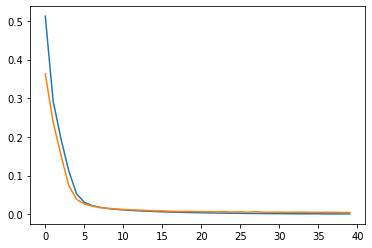

In [21]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

### Testing the model


In [27]:
def generate(text):
    encoder_input = encoding.transform(input_encoding, [text], 90)
    decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
    #decoder_input2 = encoding.transform(input_decoding,[text],80)
    decoder_input[:,0] = encoding.CHAR_CODE_START
    for i in range(1, OUTPUT_LENGTH):
        output = model.predict([encoder_input, decoder_input]).argmax(axis=2)
        decoder_input[:,i] = output[:,i]
    return decoder_input[:,1:]

def decode(decoding, sequence):
    text = ''
    text_list =[]
    for i in sequence:
        if i == 0:
            break
        text += output_decoding[i]
        text_list.append(output_decoding[i])
    return text,text_list

def correct_text(text):
    decoder_output = generate(text)
    txt,lst = decode(output_decoding, decoder_output[0])
    return txt,lst

In [47]:
k=data_input[:100]

In [23]:
k

['โรงพยาบาลบ้านแพ้วสาขาพร้อมมิตร',
 'อินทัชเมดิแคร์คลินิกเวชกรรมสาขาดินแดง',
 'โร8งพยาาลเจ้าพระยายมราช',
 'โรฤงพยาบาลรามคำแหง',
 'โรงพยาบาลแม่สะเฮียง',
 'โรงพยะาบาลลาดกระบ4งเมโมเรีย',
 'โรงพยาบาลนครพัฒน์',
 'โรงพยาบาลนิค4คำสร้ย',
 'โรงพยาบาลวิภารามนวมินร์',
 'คลินิกกรุงเทพระยงสฬขาบ้านฉาง']

In [57]:
enc = generate(k[0])

In [58]:
enc

array([[77., 39., 39., 13., 43., 54., 54., 43., 10., 43., 77., 77., 43.,
        64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.]])

In [27]:
text = k[0]
text

'โรงพยาบาลบ้านแพ้วสาขาพร้อมมิตร'

In [79]:
b = [encoder_input, decoder_input]

In [41]:
output = model.predict([encoder_input, decoder_input]).argmax(axis=2)

In [46]:
for i in range(1, OUTPUT_LENGTH):
        output = model.predict([encoder_input, decoder_input]).argmax(axis=2)
        decoder_input[:,i] = output[:,i]

In [31]:
decoder_output = decoder_input

In [32]:
 txt,lst = decode(output_decoding, decoder_output[0])

In [45]:
''.join(lst[2:])

'โรงพยาบาลบ้านแพ้วสาขาพร้อมมิตร'

In [87]:
x1= np.reshape(training_encoder_input[0,:],(1,80))
x2= np.reshape(training_decoder_input[0,:],(1,80))

In [91]:
out = model.predict([x1,x2]).argmax(axis=2)

In [92]:
out

array([[51, 77, 52, 39, 13, 43, 43, 54, 54, 10, 10, 77, 77, 77, 54,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]],
      dtype=int64)

In [ ]:
encoder_input = encoding.transform(input_encoding, [text], 80)

for i in range(1, OUTPUT_LENGTH):
    output = model.predict([encoder_input, decoder_input]).argmax(axis=2)
    decoder_input[:,i] = output[:,i]

In [136]:
output = model.predict([training_encoder_input,training_decoder_input])

In [141]:
res = output - training_decoder_output

In [145]:
idx = output.argmax(axis=2)

In [147]:
idx.shape

(27865, 80)

In [49]:
pred_out =[]
for i,name in enumerate(k):
    a,b =to_katakana(name)
    out = data_output[i]
    print(name,'>', a,'>',out[1:])
    pred_out.append(to_katakana(name))

โรงพยาบาลบ้านแพ้วสาขาพร้อมมิตร > 	โรงพยาบาลบ้านแพ้วสาขาพร้อมมิตร > โรงพยาบาลบ้านแพ้วสาขาพร้อมมิตร
อินทัชเมดิแคร์คลินิกเวชกรรมสาขาดินแดง > 	อินทัชเมดิแคร์คลินิกเวชกรรมสาขาดินแดง > อินทัชเมดิแคร์คลินิกเวชกรรมสาขาดินแดง
โร8งพยาาลเจ้าพระยายมราช > 	โรงพยาบาลเจ้าพระยายมราช > โรงพยาบาลเจ้าพระยายมราช
โรฤงพยาบาลรามคำแหง > 	โรงพยาบาลรามคำแหง > โรงพยาบาลรามคำแหง
โรงพยาบาลแม่สะเฮียง > 	โรงพยาบาลแม่สะเรียง > โรงพยาบาลแม่สะเรียง
โรงพยะาบาลลาดกระบ4งเมโมเรีย > 	โรงพยาบาลลาดกระบุรเทศโลเตอร์ > โรงพยาบาลลาดกระบังเมโมเรียล
โรงพยาบาลนครพัฒน์ > 	โรงพยาบาลนครพัฒน์ > โรงพยาบาลนครพัฒน์
โรงพยาบาลนิค4คำสร้ย > 	โรงพยาบาลนิคมคำสร้อย > โรงพยาบาลนิคมคำสร้อย
โรงพยาบาลวิภารามนวมินร์ > 	โรงพยาบาลวิภาราม นวมินทร์ > โรงพยาบาลวิภาราม นวมินทร์
คลินิกกรุงเทพระยงสฬขาบ้านฉาง > 	คลินิกกรุงเทพระยองสาขาบ้านฉาง > คลินิกกรุงเทพระยองสาขาบ้านฉาง
โจรงพยาบาลบึงบูรพ์ > 	โรงพยาบาลบึงบูรพ์ > โรงพยาบาลบึงบูรพ์
โรงพยาบาลหม่ทะ > 	โรงพยาบาลหมะทร > โรงพยาบาลแม่ทะ
โรง่ยาบาลกรุงเทพตราด > 	โรงพยาบาลกรุงเทพตราด > โรงพยาบาลกรุงเทพตราด
โรงพยาบาลเมื

In [86]:
encoder_input = encoding.transform(input_encoding, [data_input[0]], 93)

In [80]:
data_test = pd.read_csv('../datasets/hospital_augment_test6_3.csv')

In [81]:
data_input_test = list(data_test['gen_data'])
data_output_test = list(data_test['true_data'])

In [30]:
pred_test = []
count = 0
for i in range(len(data_input_test)):
    a,b =correct_text(data_input_test[i])
    pred_test.append(a)
    out = data_output_test[i]
    print(data_input_test[i],'>', a,'>',out)
    if str(out) == a[1:]:
        count +=1

แม่วงก์ > โรงพยาบาลแม่วงก์
โรงพยาบ-าีลแม่วาง > 	โรงพยาบาลแม่วาง > โรงพยาบาลแม่วาง
โรงรยาบาลแม่สรวย > 	โรงพยาบาลแม่สรวย > โรงพยาบาลแม่สรวย
โรงพยาาลแม่สอด > 	โรงพยาบาลแม่สอด > โรงพยาบาลแม่สอด
โรงพยาบาลแม่สอด-รา์ > 	โรงพยาบาลแม่สอดราม > โรงพยาบาลแม่สอด-ราม
โรงพยาบาลแม่สะเ/ียง > 	โรงพยาบาลแม่สะเรียง > โรงพยาบาลแม่สะเรียง
โรงพยบาลแม่ออีน > 	โรงพยาบาลแม่ออน > โรงพยาบาลแม่ออน
โรงพยานาลยะลา > 	โรงพยาบาลยะลา > โรงพยาบาลยะลา
โรงพยขบาลยะหริ่ง > 	โรงพยาบาลยะหริ่ง > โรงพยาบาลยะหริ่ง
โรงพยาบาลยางช1ุมน้อฒย > 	โรงพยาบาลยางชุมน้อย > โรงพยาบาลยางชุมน้อย
โรงพยาบาลย่่นตาขาว > 	โรงพยาบาลย่านตาขาว > โรงพยาบาลย่านตาขาว
โรญพยคบาละี่งเฉลิมพระเกียรติ 80 พรรษา > 	โรงพยาบาลยี่งเสาราชนครราชสีมา > โรงพยาบาลยี่งอเฉลิมพระเกียรติ 80 พรรษา
โรงพยาบาัร่มฉัตร > 	โรงพยาบาลร่มฉัตร > โรงพยาบาลร่มฉัตร
โรงพฒยาบาลรวมชัยปร-ะชารักษฐ์ > 	โรงพยาบาลรวมชัยประชารักษ์ > โรงพยาบาลรวมชัยประชารักษ์
โรงพ์ยาบาลรวมแพทย์(หมออนันต์) > 	โรงพยาบาลรวมแพทย์(หมออนันต์) > โรงพยาบาลรวมแพทย์(หมออนันต์)
โรุพยาบาลรวมแพทย์ภชัยนาท > 	โรงพยาบาลรวมแพทย์ชัยน

KeyboardInterrupt: 

In [45]:
for i in range(8085,len(data_input_test)):
    a,b =correct_text(data_input_test[i])
    pred_test_new.append(a)
    out = data_output_test[i]
    print(data_input_test[i],'>', a,'>',out)
    print(i)
    if str(out) == a[1:]:
        count +=1

สถ0นพยาบาลจุฬาเวช > 	สถานพยาบาลจุฬาเวช > สถานพยาบาลจุฬาเวช
8085
สถาพยาบาลนราการแพทฎ์ > 	สถานพยาบาลนราการแพทย์ > สถานพยาบาลนราการแพทย์
8086
สถานพยาบาลฑบางนา3 > 	สถานพยาบาลแกลวง > สถานพยาบาลบางนา3
8087
สถานพยาบฒาลบารมีการแพทย์ > 	สถานพยาบาลบารมีการแพทย์ > สถานพยาบาลบารมีการแพทย์
8088
สถานพยาบาลเมืองผมุทรบางปู > 	สถานพยาบาลเมืองสมุทรบางปู > สถานพยาบาลเมืองสมุทรบางปู
8089
สถานพยาบํรรวมแพทยญ์ทุ่งสง > 	สถานพยาบาลรวมแพทย์ทุ่งสง > สถานพยาบาลรวมแพทย์ทุ่งสง
8090
สถานพ.ยาบาลเวชกรรมทั่วไปสายไหม(คลอง8) > 	สถานพยาบาลเวชกรรมทั่วไปสายไหม(คลอง8) > สถานพยาบาลเวชกรรมทั่วไปสายไหม(คลอง8)
8091
สถานพยาบาลเวชกรรม5นครหล่ํม > 	สถานพยาบาลเวชกรรมนครหล่ม > สถานพยาบาลเวชกรรมนครหล่ม
8092
สถาํนพยาบาลเวชกรรมบางปะกอก2 > 	สถานพยาบาลเวชกรรมบางปะกอก2 > สถานพยาบาลเวชกรรมบางปะกอก2
8093
สถานพยางาลเวชกรรมพาลซ > 	สถานพยาบาลเวชกรรมพาเลซ > สถานพยาบาลเวชกรรมพาเลซ
8094
สถาพพยาบาลอมตะเวชกรรมบ่อวิน > 	สถานพยาบาลอมตะเวชกรรมบ่อวิน > สถานพยาบาลอมตะเวชกรรมบ่อวิน
8095
สถานพยาบงลอิมพีเรีย)ล > 	สถานพยาบาลอิมพีเรียล > สถานพยาบาลอิมพีเรียล
8

In [46]:
len(pred_test_new)

8180

In [47]:
pred_test_new[8085],data_output_test[8085]

('\tสถานพยาบาลจุฬาเวช', 'สถานพยาบาลจุฬาเวช')

In [49]:
pred_test_df = pd.DataFrame(pred_test_new)

In [50]:
pred_test_df.columns = ['pred_test']

In [51]:
pred_test_df.to_csv('Predict_Test.csv',index=False)

In [86]:
count =0
wrong_pred =[]
wrong_true =[]
wrong_input = []
for i,key in enumerate(pred_test_new):
    test = key[1:]
    if test.replace(' ','') == data_output_test[i].replace(' ',''):
        count += 1
    else:
        wrong_pred.append(test)
        wrong_true.append(data_output_test[i])
        wrong_input.append(data_input_test[i])

In [87]:
count

7317

In [91]:
count- len(data_input_test)

-863

In [90]:
count/len(data_input_test)

0.8944987775061125

In [88]:
#### Incorrect sentence ####
for i,value in enumerate(wrong_input):
    print('Input:', wrong_input[i])
    print('Prediction:', wrong_pred[i])
    print('Gound Thrust:', wrong_true[i])
    print('-')

นย์อนามัยที่ 6
Gound Thrust: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 5
-
Input: โรงพยาบาลสตจล
Prediction: โรงพยาบาลสติาแพ
Gound Thrust: โรงพยาบาลสตูล
-
Input: โรงพยาบาลสมเด็จพระุพราชเาชอดม
Prediction: โรงพยาบาลสมเด็จพระยุพราชเด่นชัย
Gound Thrust: โรงพยาบาลสมเด็จพระยุพราชเดชอุดม
-
Input: โรงพยาบาลสมด็จพแระยุพราชธาตุพนั
Prediction: โรงพยาบาลสมเด็จพระยุพราชธาตุพนมโขง
Gound Thrust: โรงพยาบาลสมเด็จพระยุพราชธาตุพนม
-
Input: โรงพยาบาลสฎิภิ๎วชธนบุรี
Prediction: โรงพยาบาลสินศิวเวช
Gound Thrust: โรงพยาบาลสมิติเวชธนบุรี
-
Input: โรงพยาบาลสระ้บสถ์
Prediction: โรงพยาบาลสระบุรี
Gound Thrust: โรงพยาบาลสระโบสถ์
-
Input: โรงพยาบาลสวภางอารซณ์
Prediction: โรงพยาบาลสวนทรบุรี
Gound Thrust: โรงพยาบาลสว่างอารมณ์
-
Input: โรงพยาบาล์อง
Prediction: โรงพยาบาลลอง
Gound Thrust: โรงพยาบาลสอง
-
Input: โรงพยาบาล7ันป็าตอง
Prediction: โรงพยาบาลชัยนาหลง
Gound Thrust: โรงพยาบาลสันป่าตอง
-
Input: โรงพยาบาลสดนแพทย์
Prediction: โรงพยาบาลสามพนางน
Gound Thrust: โรงพยาบาลสินแพทย์
-
Input: โรงพยาบาลเสลภูม์
Prediction: โรงพยาบาลเ

In [63]:
from char_error_rate import get_char_error_rate

In [64]:
def createSpace_for_cer(text):
    re = []
    for t in text :
        re.append(t)
        
    #re.append("<eow>")
    #pad_list = ["<pad>"]*(max_seq-len(re)+index)
    #re_pad = re + pad_list
    return re

In [71]:
pred_test_output = []
for txt in pred_test_new:
    pred_test_output.append(createSpace_for_cer(txt[1:]))

In [66]:
ground_test =[]
for txt in data_output_test:
    ground_test.append(createSpace_for_cer(txt))

In [67]:
input_test = []
for txt in data_input_test:
    input_test.append(createSpace_for_cer(txt))

In [73]:
cer = 0
for i,key in enumerate(ground_test):
    cer += get_char_error_rate(ground_test[i],pred_test_output[i])
cer_mean = cer/len(ground_test)  
print('Character Error Rate for Test Set:{}%'.format(cer_mean))

Character Error Rate for Test Set:3.179324964634192%


In [74]:
cer = 0
for i,key in enumerate(ground_test):
    cer += get_char_error_rate(ground_test[i],input_test[i])
    #print(get_char_error_rate(ground_test[i],pred_test_output[i]))
cer_mean = cer/len(ground_test)  
print('Character Error Rate for Test Set:{}%'.format(cer_mean))

Character Error Rate for Test Set:7.592954013946989%


In [79]:
cer/8180

7.592954013946989

# Visualize Attention

The next step is visualizing the attention values of the medel during the translation. 

To do that, the first step is to locate "attention" layer of the model. The attention layer is the 7th layers of the model (`model.layers[7]`), which is the softmax activation-layer after dot-score. Or we can also simply call `model.get_layer('attention')` as we previously name the layer as "attention".

In [50]:
layers = model.layers
for l in layers:
    print('%s\tname:%s' % (str(l), l.name))
    
assert(model.layers[8] == model.get_layer('attention'))

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001C791150308>	name:input_1
<tensorflow.python.keras.layers.embeddings.Embedding object at 0x000001C7904F7B48>	name:embedding
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001C791150408>	name:input_2
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x000001C7DD9CE6C8>	name:lstm
<tensorflow.python.keras.layers.embeddings.Embedding object at 0x000001C790576088>	name:embedding_1
<tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x000001C798924608>	name:tf_op_layer_strided_slice
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x000001C791150AC8>	name:lstm_1
<tensorflow.python.keras.layers.merge.Dot object at 0x000001C7DD9DFF08>	name:dot
<tensorflow.python.keras.layers.core.Activation object at 0x000001C7DD9DF508>	name:attention
<tensorflow.python.keras.layers.merge.Dot object at 0x000001C792CE0348>	name:dot_1
<tensorflow.python.keras.layers.merge.Concate

We also need to re-build the model so that it returns the output from the attention layer in addition to the normal output.

In [57]:
attention_layer = model.get_layer('attention') # or model.layers[7]
#attention_layer = model.layers[8]
attention_model = Model(inputs=model.inputs, outputs=model.outputs + [attention_layer.output])

print(attention_model)
print(attention_model.output_shape)

[(None, 90, 91), (None, 90, 90)]


In [90]:
%matplotlib inline  
import matplotlib
import matplotlib.pyplot as plt
import seaborn

seaborn.set(font=['Tahoma'], font_scale=2)

def attent_and_generate(text):
    encoder_input = encoding.transform(input_encoding, [text.lower()], 90)
    decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
    decoder_input[:,0] = encoding.CHAR_CODE_START
    
    for i in range(1, OUTPUT_LENGTH):
        output, attention = attention_model.predict([encoder_input, decoder_input])
        decoder_input[:,i] = output.argmax(axis=2)[:,i]
        attention_density = attention[0]
        decoded_output = decode(output_decoding, decoder_input[0][1:])
        
    return attention_density, decoded_output


def visualize(text):
    attention_density,katakana = attent_and_generate(text)

    plt.clf()
    plt.figure(figsize=(20,12))
    ax = seaborn.heatmap(attention_density[:len(katakana[0]), :len(text)+1],
        xticklabels=[w for w in text],
        yticklabels=[w for w in katakana[0]])

    ax.invert_yaxis()
    plt.show()


In [85]:
attention_density, katakana = attent_and_generate(text)

In [87]:
katakana[0]

'\tโรงพยาบาลบ้านแพ้วสาขาพร้อมมิตร'

<Figure size 432x288 with 0 Axes>

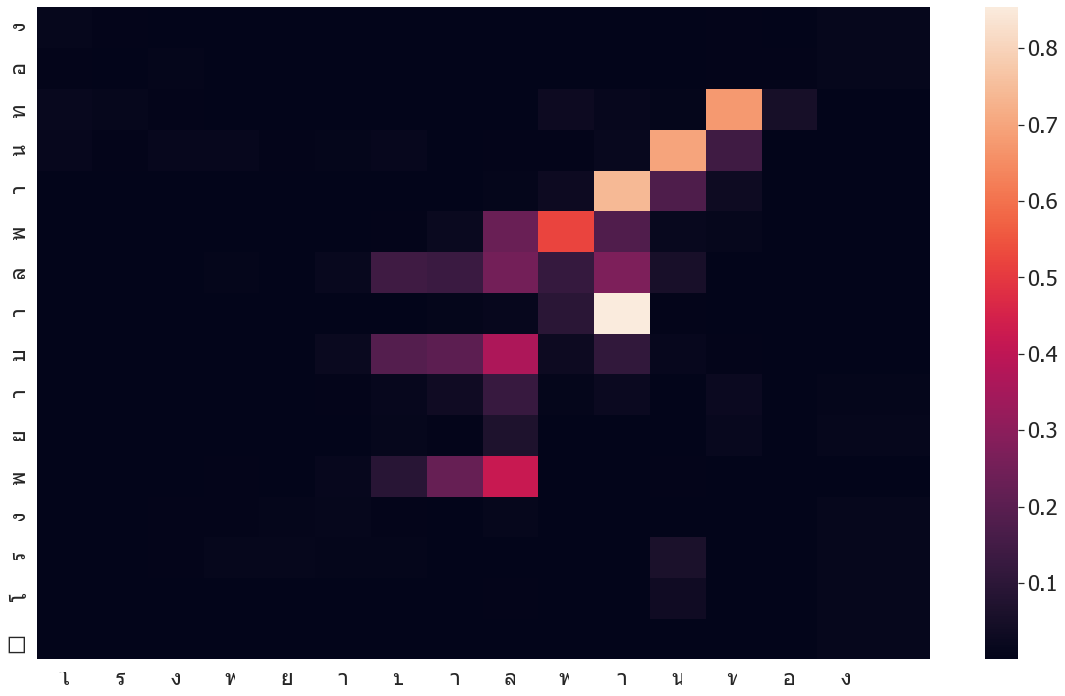

In [91]:
visualize('โรงพยาบาลพานทอง')